# Практическое домашнее задание 1. Поиск похожих изображений с помощью SVD.

Версия от 08.02.2024.

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения — поиск "хорошего" базиса (eigenfaces) в наборе изображений и использования его для поиска похожих изображений.

**Замечание:** пользоваться циклами по изображениям **запрещено**, если это явно не прописано в условии.

Для этого сначала загрузим набор изображений, на котором будем обучаться. Это набор фотографий лиц, взятый с [сайта](http://vis-www.cs.umass.edu/lfw/) проекта "Labeled faces in the wild". Скачайте лица людей с именами, начинающимися на "А" и положите в папку `data/` в рабочей директории ноутбука.

Импортируем необходимые библиотеки и загрузим картинки в виде numpy-массивов. 

In [7]:
import matplotlib.pyplot as plt
import PIL
import tarfile
import os
import numpy as np

def load_images(targz, size):
    images = {}
    tar = tarfile.open(targz, "r:gz")
    for tarinfo in tar:
        if tarinfo.isreg():
            file = tar.extractfile(tarinfo)
            image = PIL.Image.open(file)
            image = image.convert("L")
            image = image.resize(size, PIL.Image.LANCZOS)
            image = np.asarray(image, dtype=np.double)
            image /= np.linalg.norm(image)
            parts = os.path.normpath(tarinfo.name).split(os.path.sep)
            images.setdefault(parts[-2], []).append(image)
    return images

In [8]:
size = 256 #
images = load_images("data/lfw-a.tgz", (size, size))

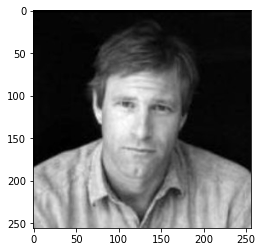

In [9]:
_ = plt.imshow(images["Aaron_Eckhart"][0], cmap="gray")

Сразу отложим одно изображение для последующего поиска.



In [6]:
test_image = images["Alejandro_Toledo"][10]
del images["Alejandro_Toledo"][10]

### a. Применение базового алгоритма SVD (35 баллов)

1. **(4 балла)** С помощью функции ```np.reshape(...)``` получите из словаря `images` массив ```M``` размера ```(size * size, nframes)```, каждым столбцом которого является изображение размера ```(size, size)```, представленное в виде вектора длины ```size**2``` (используйте такое значение параметра `order`, чтобы обходить картинки по столбцам).

*В этом пункте (и только в этом) можно использовать цикл по изображениям.*

In [10]:
M = []
for key in images.keys():
    for im in images[key]:
        image_vector = np.reshape(im, size*size, order='F')
        M.append(image_vector)
M = np.array(M).T


2. **(10 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd``` и постройте график сингулярных чисел, отсортированных по убыванию. Шкала с сингулярными числами должна быть логарифмической. Например, для этого можно использовать функцию ```plt.semilogy```.
 
    **Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел.

In [32]:
u, s, vh = np.linalg.svd(M, full_matrices= False)


In [33]:
s[::-1].sort()


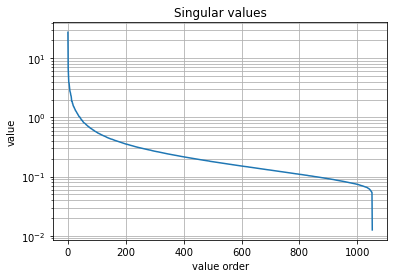

In [34]:
values = [i for i in range(len(s))] 
plt.grid(True, which ="both") 
plt.semilogy(values, s) 
plt.title('Singular values') 
plt.xlabel('value order') 
plt.ylabel('value') 
plt.show() ## второй график

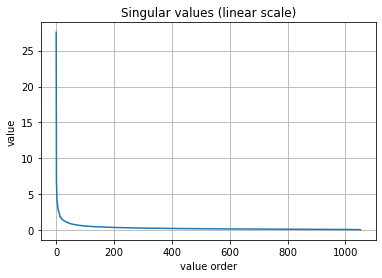

In [35]:
values = [i for i in range(len(s))] 
plt.grid(True, which ="both") 
plt.plot(values, s) 
plt.title('Singular values (linear scale)') 
plt.xlabel('value order') 
plt.ylabel('value') 
plt.show()

И правда ничего не видно....

 3. **(5 баллов)** Заполните пропуск в следующей функции, которая должна визуализировать вектор-столбцы нашей матрицы в виде таблицы. Затем с её помощью визуализируйте несколько первых сингулярных векторов. Опишите неформально, за что отвечают три старших сингулярных вектора.

Кажется, первые сингулярные векторы отвечают за наиболее общие и часто встречающиеся признаки картинок, то есть за очертания головы и верхей части тела. Они задают основные варианты освещенности фото, линейная комбинация которых потом формирует результирующую схему освещенности картинки

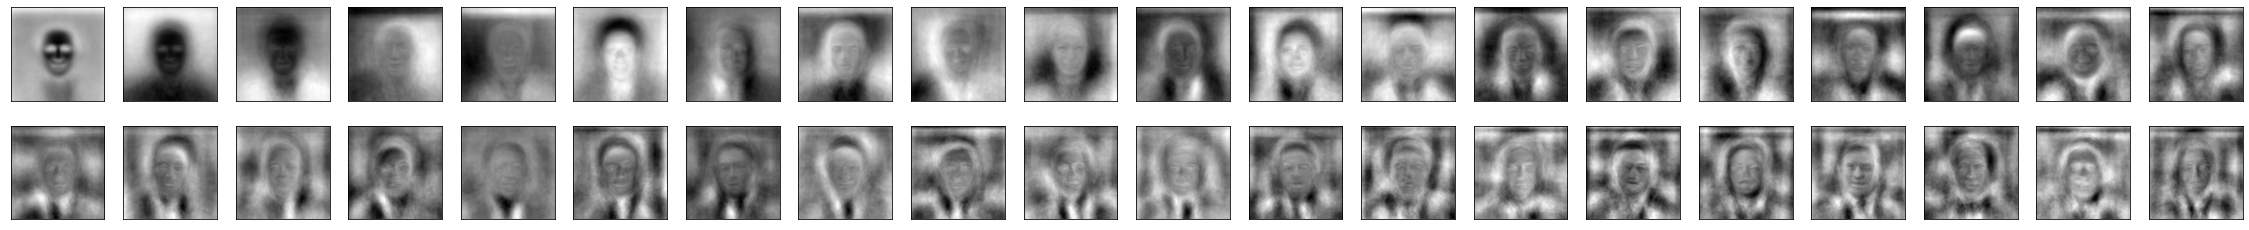

In [36]:
def plot_as_images(mat, rows, cols):
    '''
        Visualize images from the columns of mat in a table of shape (rows, cols).

        Input
            mat: numpy array of shape (size * size, rows * cols)
            rows: number of rows in the table
            cols: number of columns in the table
    '''
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2,rows*2))
    for i in range(rows):
        for j in range(cols):
            axes[i,j].imshow(mat[:,i*cols + j].reshape((size, size), order='F'), cmap="gray")
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)

plot_as_images(u, 2, 20)
plt.show()

4. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая вычисляет оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга. Функция должна возвращать матрицы $U$ и $C$ такие, что столбцы матрицы $U$ составляют ортонормированный базис столбцов $M_{r}$, а $UC = M_{r}$. Также функция `trunc_svd` возвращает **относительную** точность приближения во Фробениусовой норме, т.е.
$$
    \frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для вычисления относительной точности используйте только полученные из сингулярного разложения сингулярные числа.

In [37]:
def trunc_svd(M, r):
    '''
        Input
            M: original 2D numpy array
            r: rank value for truncation
            
        Output
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            rel_eps: relative error of rank-r approximation Mr
    '''
    U, S, Vh = np.linalg.svd(M, full_matrices=False)
    C = np.diag(S[:r]) @ Vh[:r, :]
    rel_eps = np.linalg.norm(S[r:]) / np.linalg.norm(S)
    return U[:,:r], C, rel_eps

5. **(6 баллов)** Проверим работу написанной функции. Для этого воспользуемся функцией, которая рисует исходное изображение, приближение некоторого ранга, а также первые `count` сингулярных векторов в разложении вместе с их коэффициентами. Заполните пропуски в ней с помощью метода `reshape`.

In [38]:
def plot_as_combination(M, U, C, count, indices):
    '''
        Input
            M: original 2D numpy array
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            count: desired number of images of singular vectors
            indices: indices of columns of M which are visualized
    '''

    fig, all_axes = plt.subplots(len(indices), count + 2, figsize=(count * 2, len(indices)*2))

    for i, index in enumerate(indices):
        axes = all_axes[i, :]

        axes[0].imshow(M[:, index].reshape((256, 256), order='f'), cmap="gray",) # Original image
        axes[0].set_xlabel("Orig")

        appr = U @ C[:, index]
    
        axes[1].imshow(appr.reshape((256, 256), order='f'), cmap="gray") # Approximation image
        axes[1].set_xlabel("Appr")

        for i in range(count):
            axes[2 + i].imshow(U[:, i].reshape((256, 256), order='f'), cmap="gray") # i-th singular vector image
            axes[2 + i].set_xlabel("{:.7}".format(C[i, index]))
        
        for ax in axes:
            ax.set_xticks([])
            ax.get_yaxis().set_visible(False)

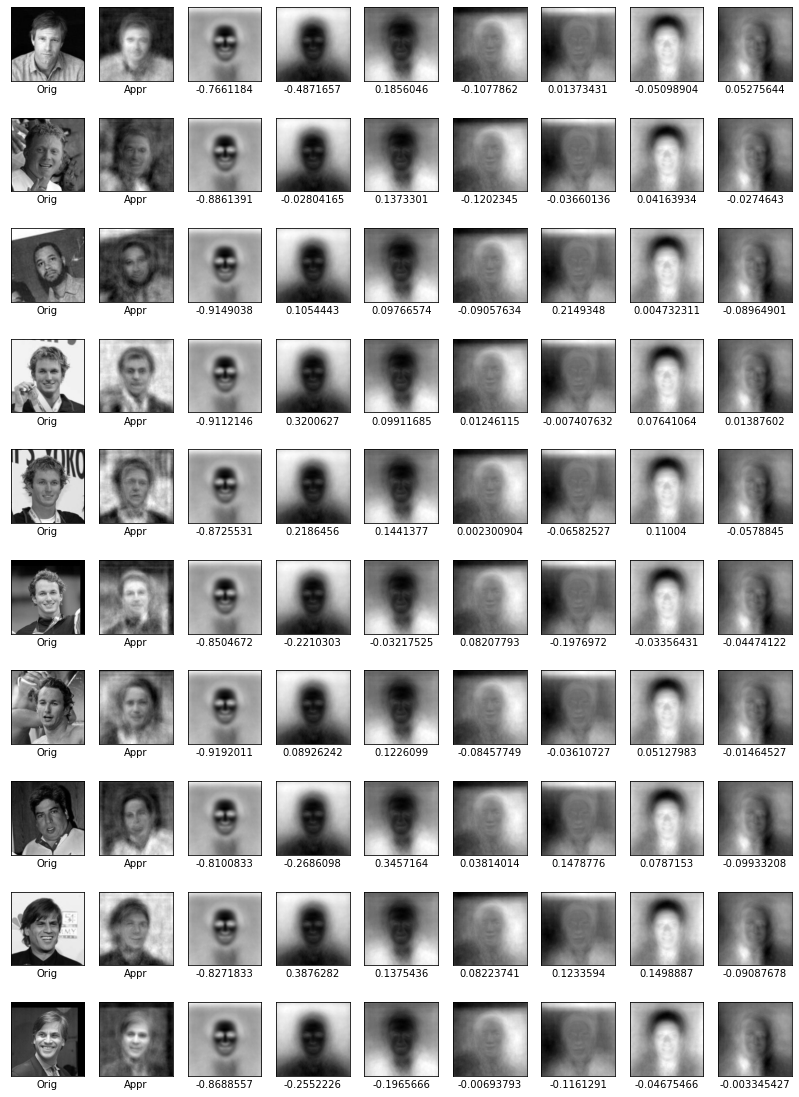

In [39]:
U, C, eps = trunc_svd(M, 100)
plot_as_combination(M, U, C, 7, range(10))


### b. Применение рандомизированного алгоритма SVD (35 баллов)

Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого (кубического) роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений.

1. **(20 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + p``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы **не вычисляете** в явном виде матрицу $QQ^*$.

In [11]:
def rand_svd(M, r, p=10):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            p: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    
    n = M.shape[1]
    Omega = np.random.randn(n, r + p)
    Y = M @ Omega
    Q, R = np.linalg.qr(Y)
   
    U, S, Vh = np.linalg.svd(Q.T @ M, full_matrices= False)
    Res = (Q @ U)[:, :r] @ np.diag(S[:r]) @ Vh[:r, :]
    rel_eps = np.linalg.norm(Res - M, ord='fro')/np.linalg.norm(M, ord='fro')

    return Res, rel_eps  
    
    
    


2. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M_{SVD} - M||_F} - 1
$$
в зависимости от $p$ для $r=50$. По $p$ выберите сетку $[0, 100]$ с шагом 5.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу.

In [41]:
p = [i for i in range(0, 101, 5)]
func_v = []
U, C, rel_eps = trunc_svd(M, 50)
M_r = U @ C 

In [42]:
for i in p:
    curr_f = 0
    curr_f_eps = 0
    for _ in range(10):
        M_rand, rel_eps_rand =  rand_svd(M, r = 50, p = i)
        curr_f_eps += rel_eps_rand/rel_eps - 1
    func_v.append(curr_f_eps/10)


        
        

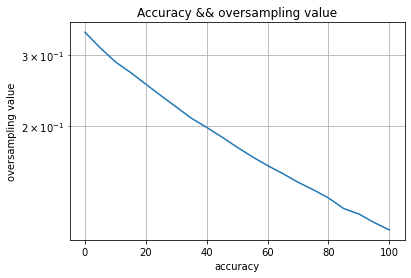

In [43]:
plt.grid(True, which ="both") 
plt.semilogy(p, func_v) 
plt.title('Accuracy && oversampling value') 
plt.xlabel('accuracy') 
plt.ylabel('oversampling value') 
plt.show() 

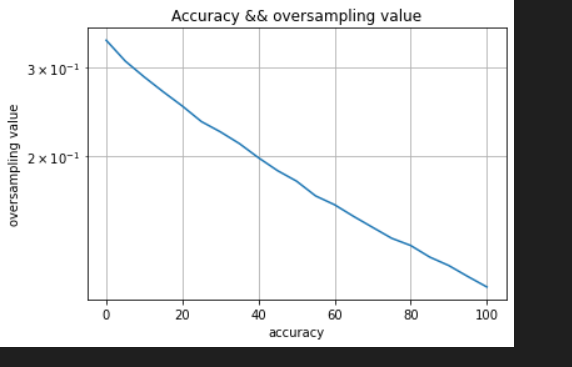

3. **(5 баллов)** С помощью ```%timeit``` сравните время расчета для ```trunc_svd``` и ```rand_svd``` для ранга $r = 50$. Во сколько раз рандомизированный алгоритм быстрее ```np.linalg.svd``` для матрицы ```M```?

In [44]:


%timeit U, C, rel_eps = trunc_svd(M, 50)

%timeit M_rand, rel_eps = rand_svd(M, r=50)


13.1 s ± 732 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.92 s ± 56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


получили, что рандомизированный алгоритм быстрее почти в 7 раза (в основе trunc_svd лежит np.linalg.svd)

тут выходят постоянно разные значения времени, видимо зависит от рандома и насколько ноуту плохо в моменте от других задач))

In [13]:
import time
time_=0
for i in range(10):
    start_=time.time()
    rand_svd(M, 50)
    end_=time.time()
    time_+=(end_-start_)
print(time_/10)    

2.389465355873108


Тут я еще решила усредненное посчитать

### c. Поиск нового изображения (30 баллов)

Представьте, что нам выдали новое изображение `new`, которого в нашей базе нет. Чтобы найти в базе похожие, можно посчитать норму разности с каждым имеющимся изображением. Для проверки напишем вспомогательную функцию, которая будет показывать подписанные картинки.

In [45]:
def show_images(M, indices, names):
    fig, axes = plt.subplots(1, len(indices), figsize=(len(indices)*3, 3))
    for ax, index in zip(axes, indices):
        ax.imshow(M[:,index].reshape((size, size), order="F"), cmap="gray")
        ax.get_xaxis().set_ticks([])
        ax.set_xlabel(names[index])
        ax.get_yaxis().set_visible(False)

   1. **(10 баллов)** Напишите функцию, находящее ближайшее во фробениусовой норме изображение.

In [46]:
def get_closest_naive(M, new_v, count):
    """
        Input
            M: matrix of vectorized images
            new_v: new image as a vector of shape (size**2,)
            count: desired number of closest images
            
        Output
            indices: list of count indices of closest images
    """
    n = M.shape[1]
    indices = np.argsort(np.linalg.norm(np.outer(new_v, n) - M, axis=0))
    indices = indices[:count]
    
    return indices


Проверим её на тестовом изображении. Как минимум один Алехандро Толедо должен найтись.

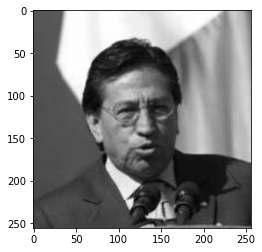

In [47]:
new = test_image
_ = plt.imshow(new, cmap="gray")

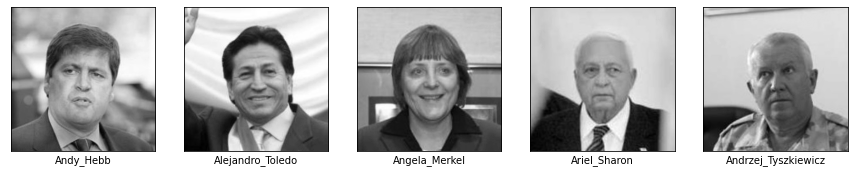

In [48]:
new_v = new.ravel(order="F")
names = sum(map(lambda item: [item[0]] * len(item[1]), images.items()), [])
show_images(M, get_closest_naive(M, new_v, 5), names)

Помимо того, что такой подход может оказаться неприемлемым с точки зрения производительности, он также не устойчив:  например, изменение освещения или фона может очень сильно изменить норму разности.

   2. **(20 баллов)** Применим подход, использующий SVD. Именно, спроецируем новое изображение на пространство, задаваемое ортонормированным базисом $U$, и будем сравнивать норму разности проекций. Причём для устойчивости к изменению освещения не будем учитывать первую компоненту в разложении по столбцам матрицы $U$. Напишите функцию `get_closest_proj`, которая возвращает индексы `count` изображений по описанному алгоритму.

In [49]:
def get_closest_proj(U, C, new_v, count):
    """
        Input
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            new_v: new image as a vector of shape (size**2,)
            count: desired number of closest images
            
        Output
            indices: list (of len `count`) of indices of closest images
    """

    # столбцы матрицы U - базис
    # столбцы С - координаты соотв вектора
    proj_new_v = (U[:, 1:].T @ new_v) 
    proj_new_v = U[:, 1:] @ proj_new_v
    M = U[:, 1:] @ C[1:, :]
    n = M.shape[1]
    indices = np.argsort(np.linalg.norm(np.outer(proj_new_v, np.ones(n)) - M, axis=0))
    indices = indices[:count]
    
    return indices
    
     
    

Проверим подход с SVD  том же тестовом изображении. Правильно реализованный метод должен найти как минимум два изображения Алехандро.

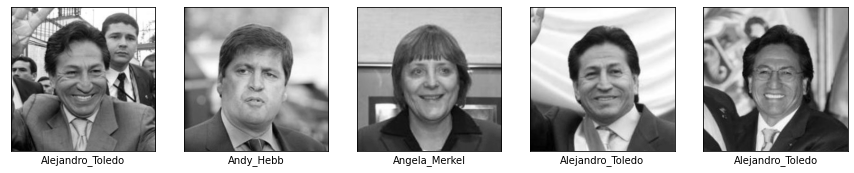

In [50]:
show_images(M, get_closest_proj(U, C, new_v, 5), names)

### c. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье 

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.

In [28]:
def func(M, r, q):
    n = M.shape[1]
    Omega = np.random.randn(n, r)
    Y0 = M @ Omega
    Q0, R0 = np.linalg.qr(Y0)
    Q_prev = Q0
    for j in range(1, q + 1):
        Y_j = M.T @ Q_prev
        Q_j, R_j = np.linalg.qr(Y_j)
        Yj = M @ Q_j
        Qj, Rj = np.linalg.qr(Yj)
        Q_prev = Qj    
    U, S, Vh = np.linalg.svd(Q_prev.T @ M, full_matrices= False)

    Res = (Q_prev @ U)[:, :r] @ np.diag(S[:r]) @ Vh[:r, :]
    return Res
q_values = [i for i in range (0, 101, 5)]
rangs = [5, 20, 50]
norm_diffs = []
for r in rangs:
    U, C, eps = trunc_svd(M, r)
    delta = []
    for q in q_values:
        print(q, 'q') # буду выводить чтобы понимать сколько это чудо работает))
        d = 0
        for i in range (10):
            alg_M = func(M, r, q)
            d += np.linalg.norm(alg_M - U@C)
        delta.append(d/10)
    norm_diffs.append(delta)

0 q
5 q
10 q
15 q
20 q
25 q
30 q
35 q
40 q
45 q
50 q
55 q
60 q
65 q
70 q
75 q
80 q
85 q
90 q
95 q
100 q
0 q
5 q
10 q
15 q
20 q
25 q
30 q
35 q
40 q
45 q
50 q
55 q
60 q
65 q
70 q
75 q
80 q
85 q
90 q
95 q
100 q
0 q
5 q
10 q
15 q
20 q
25 q
30 q
35 q
40 q
45 q
50 q
55 q
60 q
65 q
70 q
75 q
80 q
85 q
90 q
95 q
100 q


[[12.028702126337581, 2.7188529906237315, 1.3035802612277267, 0.44429880833826985, 0.14816627982944713, 0.13180907672393832, 0.012726127730044681, 0.003761531266638995, 0.006820214034424647, 0.005688556797045549, 0.0003835163112830762, 0.00010605652490213637, 0.00018266405972470052, 0.00022927140121106973, 1.1750756958685228e-05, 7.68596794059286e-06, 5.5204132074622274e-06, 1.1773961915004758e-06, 2.2511580744999123e-07, 6.256479454473605e-08, 5.324151553134457e-08], [9.643260458132868, 2.10324390266734, 1.7337890920151158, 1.209989095503541, 0.9393496430406959, 0.8806627100185821, 0.8583154403740079, 0.18734077084491196, 0.46052132342992025, 0.1787338487687634, 0.12083666562284427, 0.41603429272096415, 0.0464708583587692, 0.2571803517319051, 0.04877125472004915, 0.03456616000996181, 0.006248367257556553, 0.0209789259644712, 0.00900996416211823, 0.0046886702097416145, 0.003320572068416505], [8.325490682560632, 1.8997796053308165, 1.4626331534349037, 1.2053608361831, 0.9608270208435471

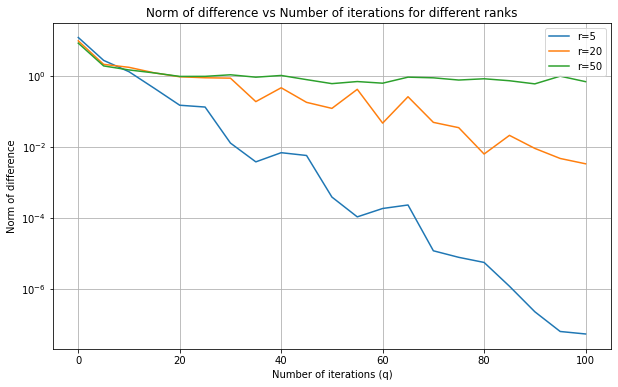

In [30]:
print(norm_diffs)
plt.figure(figsize=(10, 6))

for i in range(len(norm_diffs)):
    plt.semilogy(q_values, norm_diffs[i], label=f'r={rangs[i]}')

plt.xlabel('Number of iterations (q)')
plt.ylabel('Norm of difference')
plt.title('Norm of difference vs Number of iterations for different ranks')
plt.legend()
plt.grid()
plt.show()

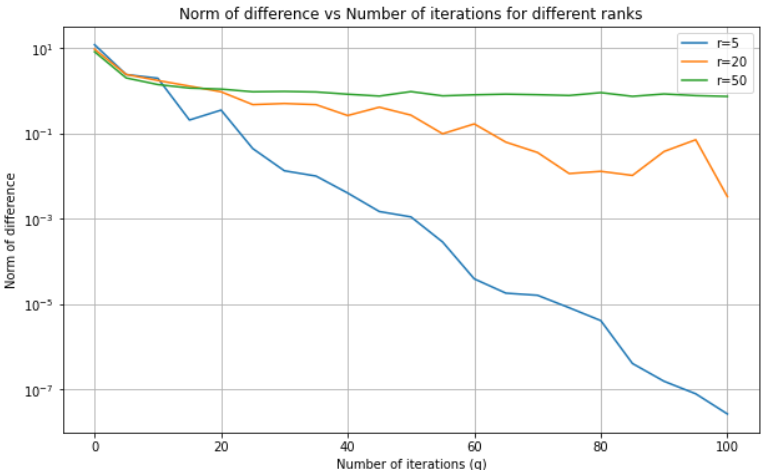

Это скрин одной из итераций, работает супер долго, запускать НЕ СТОИТ))

[[12.028702126337581, 2.7188529906237315, 1.3035802612277267, 0.44429880833826985, 0.14816627982944713, 0.13180907672393832, 0.012726127730044681, 0.003761531266638995, 0.006820214034424647, 0.005688556797045549, 0.0003835163112830762, 0.00010605652490213637, 0.00018266405972470052, 0.00022927140121106973, 1.1750756958685228e-05, 7.68596794059286e-06, 5.5204132074622274e-06, 1.1773961915004758e-06, 2.2511580744999123e-07, 6.256479454473605e-08, 5.324151553134457e-08], [9.643260458132868, 2.10324390266734, 1.7337890920151158, 1.209989095503541, 0.9393496430406959, 0.8806627100185821, 0.8583154403740079, 0.18734077084491196, 0.46052132342992025, 0.1787338487687634, 0.12083666562284427, 0.41603429272096415, 0.0464708583587692, 0.2571803517319051, 0.04877125472004915, 0.03456616000996181, 0.006248367257556553, 0.0209789259644712, 0.00900996416211823, 0.0046886702097416145, 0.003320572068416505], [8.325490682560632, 1.8997796053308165, 1.4626331534349037, 1.2053608361831, 0.9608270208435471, 0.9651576116433397, 1.0687822642576383, 0.9142665795915658, 1.0224185305133917, 0.7804558889774709, 0.6017207037946055, 0.6887871067228317, 0.6196414044109477, 0.9164481147721071, 0.8774364209384407, 0.7596421518293145, 0.8252436140872057, 0.7259826995259127, 0.5927514189984481, 0.9769380541805148, 0.6843906635680574]] это значения для графика сохранила на всякий случай